# Manifold Learning

Based on Chapter 5 from *Python for Data Science Handbook*, by Jake VanderPlas.

We have seen how principal component analysis (PCA) can be used in the dimensionality reduction task—reducing the number of features of a dataset while maintaining the essential relationships between the points.
While PCA is flexible, fast, and easily interpretable, it does not perform so well when there are *nonlinear* relationships within the data; we will see some examples of these below.

To address this deficiency, we can turn to a class of methods known as *manifold learning*—a class of unsupervised estimators that seeks to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces.
When you think of a manifold, I'd suggest imagining a sheet of paper: this is a two-dimensional object that lives in our familiar three-dimensional world, and can be bent or rolled in that two dimensions.
In the parlance of manifold learning, we can think of this sheet as a two-dimensional manifold embedded in three-dimensional space.

Rotating, re-orienting, or stretching the piece of paper in three-dimensional space doesn't change the flat geometry of the paper: such operations are akin to linear embeddings.
If you bend, curl, or crumple the paper, it is still a two-dimensional manifold, but the embedding into the three-dimensional space is no longer linear.
Manifold learning algorithms would seek to learn about the fundamental two-dimensional nature of the paper, even as it is contorted to fill the three-dimensional space.

Here we will demonstrate a number of manifold methods, going most deeply into a couple techniques: multidimensional scaling (MDS), locally linear embedding (LLE), and isometric mapping (IsoMap).

We begin with the standard imports:

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns; sns.set()

#import warnings
#warnings.filterwarnings("ignore")

## Manifold Learning: "HELLO"

To make these concepts more clear, let's start by generating some two-dimensional data that we can use to define a manifold.
Here is a function that will create data in the shape of the word "HELLO":

In [2]:
def make_hello(N=1000, rseed=42):
    
    '''
    Create a plot displaying the text "HELLO" and save it as a PNG file
    '''
    
    fig, ax = plt.subplots(figsize=(4, 1))                 # Create a figure with a specific size
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)  # Adjust subplot parameters to remove margins
    ax.axis('off')                                         # Turn off the axis lines and labels
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)  # Add text to the plot
    fig.savefig('images/hello.png')  # Save the figure as a PNG file
    plt.close(fig)                   # Close the figure to free memory
    
    # Load the saved PNG file and use it as a mask to draw random points
    from matplotlib.image import imread              # Import image reading function
    data = imread('images/hello.png')[::-1, :, 0].T  # Read the PNG and get the pixel intensity values (invert rows and transpose)
    
    rng = np.random.RandomState(rseed)  # Initialize a random number generator with a seed for reproducibility
    X = rng.rand(4 * N, 2)              # Generate random points in 2D space
    
    # Map the random points to the image coordinates
    i, j = (X * data.shape).astype(int).T  # Scale and convert the points to integer coordinates
    mask = (data[i, j] < 1)                # Create a mask where points fall within the text region (non-white pixels)
    X = X[mask]                            # Apply the mask to filter points
    
    X[:, 0] *= (data.shape[0] / data.shape[1])  # Adjust the x-coordinates to match the aspect ratio of the image
    X = X[:N]                                   # Limit the number of points to N
    
    return X[np.argsort(X[:, 0])]  # Return the points sorted by their x-coordinate

Let's call the function and visualize the resulting data:

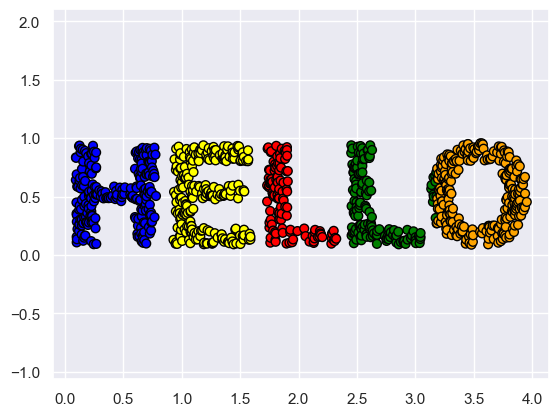

In [3]:
import matplotlib.colors as mcolors

# Generate 1000 random points that form the shape of the text "HELLO"
X = make_hello(1000)

# Define a custom colormap
colors = ['blue', 'yellow', 'red', 'green', 'orange']
cmap_name = 'custom_black_white_vivid'
custom_cmap = mcolors.ListedColormap(colors)

# Create a scatter plot with points colored according to their x-coordinate
plt.scatter(
    X[:, 0],                # X-coordinates of the points
    X[:, 1],                # Y-coordinates of the points
    c=X[:, 0],              # Color of each point determined by its x-coordinate
    s=40,                   # Size of each point (in points^2)
    cmap=custom_cmap,       # Custom colormap used for coloring the points
    edgecolor='black'       # Color of the edge of each point
)

plt.axis('equal')
plt.show()

The output is two dimensional, and consists of points drawn in the shape of the word, "HELLO". This data form will help us to see visually what these algorithms are doing.

## Multidimensional Scaling (MDS)

Looking at data like this, we can see that the particular choice of *x* and *y* values of the dataset are not the most fundamental description of the data: we can scale, shrink, or rotate the data, and the "HELLO" will still be apparent.
For example, if we use a rotation matrix to rotate the data, the *x* and *y* values change, but the data is still fundamentally the same:

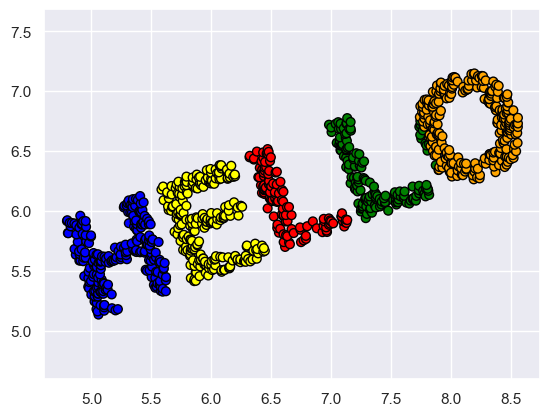

In [4]:
# Define a function to rotate a set of 2D points by a given angle
def rotate(X, angle):
    # Convert the angle from degrees to radians
    theta = np.deg2rad(angle)
    
    # Define the 2x2 rotation matrix for rotating points in the 2D plane
    R = [
        [np.cos(theta), np.sin(theta)],   # First row of the rotation matrix
        [-np.sin(theta), np.cos(theta)]   # Second row of the rotation matrix
    ]
    
    # Apply the rotation matrix to the points in X
    return np.dot(X, R)

# Rotate the original set of points X by 20 degrees and translate them by (5, 5)
X2 = rotate(X, 20) + 5

# Plot the rotated and translated points with color mapping
plt.scatter(
    X2[:, 0],               # X-coordinates of the rotated points
    X2[:, 1],               # Y-coordinates of the rotated points
    c=X[:, 0],              # Color of each point determined by its x-coordinate
    s=40,                   # Size of each point (in points^2)
    cmap=custom_cmap,       # Custom colormap used for coloring the points
    edgecolor='black'       # Color of the edge of each point
)

# Ensure the axes have equal scaling for accurate representation
plt.axis('equal');

This tells us that the *x* and *y* values are not necessarily fundamental to the relationships in the data.
What *is* fundamental, in this case, is the *distance* between each point and the other points in the dataset.
A common way to represent this is to use a distance matrix: for $N$ points, we construct an $N \times N$ array such that entry $(i, j)$ contains the distance between point $i$ and point $j$.
Let's use Scikit-Learn's efficient ``pairwise_distances`` function to do this for our original data:

In [5]:
# Import the function to compute pairwise distances between points
from sklearn.metrics import pairwise_distances

# Compute the pairwise distances between all pairs of points in X
# The result is a distance matrix where D[i, j] is the distance between point i and point j
D = pairwise_distances(X)

# Output the shape of the distance matrix D
# The shape will be (N, N) where N is the number of points in X
D.shape

(1000, 1000)

As promised, for our N=1,000 points, we obtain a 1000×1000 matrix, which can be visualized as shown here:

In [6]:
D

array([[0.00000000e+00, 1.92975904e-01, 1.89738446e-01, ...,
        3.84197456e+00, 3.84481317e+00, 3.86216644e+00],
       [1.92975904e-01, 0.00000000e+00, 3.78309501e-03, ...,
        3.84523959e+00, 3.85520174e+00, 3.87607817e+00],
       [1.89738446e-01, 3.78309501e-03, 0.00000000e+00, ...,
        3.84316550e+00, 3.85301245e+00, 3.87383327e+00],
       ...,
       [3.84197456e+00, 3.84523959e+00, 3.84316550e+00, ...,
        0.00000000e+00, 1.42234608e-01, 2.14493924e-01],
       [3.84481317e+00, 3.85520174e+00, 3.85301245e+00, ...,
        1.42234608e-01, 0.00000000e+00, 7.31472497e-02],
       [3.86216644e+00, 3.87607817e+00, 3.87383327e+00, ...,
        2.14493924e-01, 7.31472497e-02, 0.00000000e+00]])

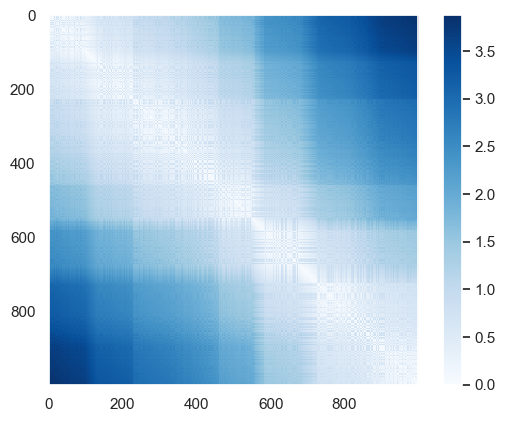

In [7]:
# Visualize the distance matrix using a heatmap

plt.imshow(D,                          # Display the distance matrix D as an image
           zorder=2,                   # zorder=2 ensures this image is layered above any existing graphics
           cmap='Blues',               # cmap='Blues' uses the 'Blues' colormap to represent different distances
           interpolation='nearest')    # interpolation='nearest' shows each element as a single color block without smoothing

# Add a colorbar to the plot, which indicates the scale of the distances
plt.colorbar();

If we similarly construct a distance matrix for our rotated and translated data, we see that it is the same:

In [8]:
# Compute the pairwise distances for the rotated and translated dataset X2
D2 = pairwise_distances(X2)

# Check if the distance matrices D and D2 are approximately equal
np.allclose(D, D2)       # np.allclose returns True if two arrays are element-wise equal within a tolerance

True

This distance matrix gives us a representation of our data that is invariant to rotations and translations, but the visualization of the matrix above is not entirely intuitive.
In the representation shown in this figure, we have lost any visible sign of the interesting structure in the data: the "HELLO" that we saw before.

Further, while computing this distance matrix from the (x, y) coordinates is straightforward, transforming the distances back into *x* and *y* coordinates is rather difficult.
This is exactly what the multidimensional scaling algorithm aims to do: given a distance matrix between points, it recovers a $D$-dimensional coordinate representation of the data.
Let's see how it works for our distance matrix, using the ``precomputed`` dissimilarity to specify that we are passing a distance matrix:

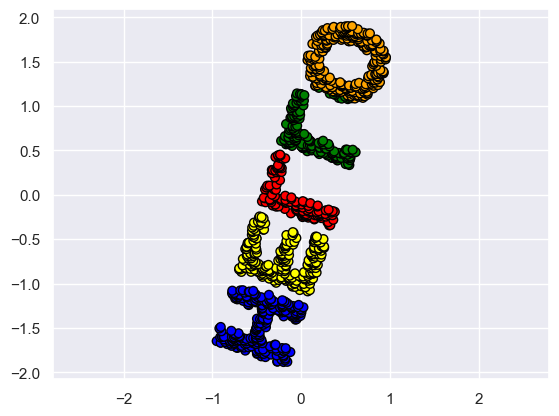

In [9]:
from sklearn.manifold import MDS  # Import the Multidimensional Scaling (MDS) class from sklearn.manifold

# Initialize the MDS model

model = MDS(n_components=2,               # n_components=2 specifies that we want to project the data onto 2 dimensions
            dissimilarity='precomputed',  # dissimilarity='precomputed' means we will provide a precomputed dissimilarity (distance) matrix
            random_state=1)               # random_state=1 ensures reproducibility by fixing the random seed

# Fit the model using the precomputed distance matrix D and transform it into a 2D representation
# The fit_transform method both fits the model to the distance data and transforms the data
out = model.fit_transform(D)

# Create a scatter plot of the 2D transformed data
plt.scatter(
    out[:, 0],              # X-coordinates of the points
    out[:, 1],              # Y-coordinates of the points
    c=X[:, 0],              # Color of each point determined by its x-coordinate
    s=40,                   # Size of each point (in points^2)
    cmap=custom_cmap,       # Custom colormap used for coloring the points
    edgecolor='black'       # Color of the edge of each point
)

# Ensure that the aspect ratio is equal so that the units are the same in every direction
plt.axis('equal');

The MDS algorithm recovers one of the possible two-dimensional coordinate representations of our data, using *only* the $N\times N$ distance matrix describing the relationship between the data points.

What happened if we change c=X to c=out?

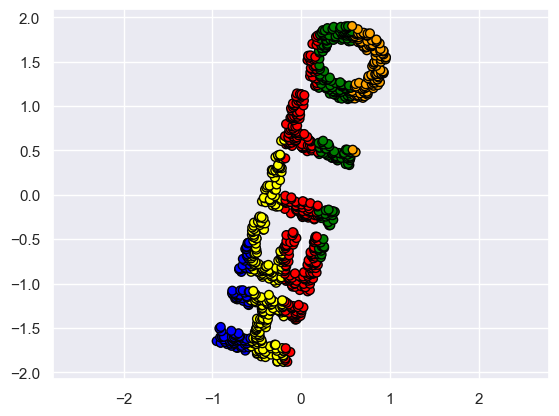

In [10]:
# Create a scatter plot of the 2D transformed data but changing c=X to c=out.
plt.scatter(
    out[:, 0],              # X-coordinates of the points
    out[:, 1],              # Y-coordinates of the points
    c=out[:, 0],            # Color of each point determined by its x-coordinate
    s=40,                   # Size of each point (in points^2)
    cmap=custom_cmap,       # Custom colormap used for coloring the points
    edgecolor='black'       # Color of the edge of each point
)

# Ensure that the aspect ratio is equal so that the units are the same in every direction
plt.axis('equal');

## MDS as Manifold Learning

The usefulness of this becomes more apparent when we consider the fact that distance matrices can be computed from data in *any* dimension.
So, for example, instead of simply rotating the data in the two-dimensional plane, we can project it into three dimensions using the following function (essentially a three-dimensional generalization of the rotation matrix used earlier):

In [11]:
def random_projection(X, dimension=3, rseed=42):
    # Ensure the target dimension is at least as large as the input dimension
    assert dimension >= X.shape[1]

    # Initialize a random number generator with a fixed seed for reproducibility
    rng = np.random.RandomState(rseed)

    # Generate a random matrix of shape (dimension, dimension)
    C = rng.randn(dimension, dimension)

    # Compute the eigenvalues and eigenvectors of the matrix C*C^T
    e, V = np.linalg.eigh(np.dot(C, C.T))

    # Project the data X onto the space spanned by the first few eigenvectors
    # The number of eigenvectors used is determined by the original dimension of X
    return np.dot(X, V[:X.shape[1]])

# Apply random projection to the data X, projecting it into 3 dimensions
X3 = random_projection(X, 3)

# Output the shape of the projected data, which should be (number of samples, 3)
X3.shape

(1000, 3)

Let's visualize these points to see what we're working with:

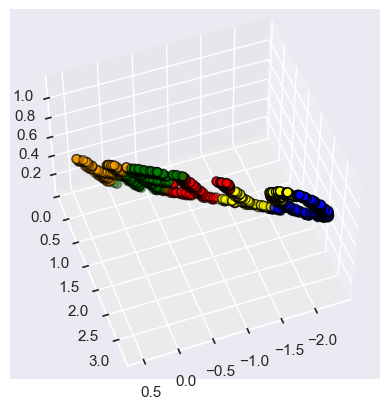

In [12]:
from mpl_toolkits import mplot3d  # Import the 3D plotting toolkit from Matplotlib

# Create a 3D plot with the '3d' projection
ax = plt.axes(projection='3d')

# Scatter plot the 3D data with the color mapping defined earlier
ax.scatter3D(
    X3[:, 0],              # X-coordinates of the points
    X3[:, 1],              # Y-coordinates of the points
    X3[:, 2],              # Z-coordinates of the points
    c=X3[:, 0],            # Color of each point determined by its x-coordinate
    s=40,                  # Size of each point (in points^2)
    cmap=custom_cmap,      # Custom colormap used for coloring the points
    edgecolor='black')     # Color of the edge of each point

# Set the initial view angle for the 3D plot
ax.view_init(azim=70, elev=50)  # Azimuth angle of 70 degrees and elevation angle of 50 degrees

We can now ask the ``MDS`` estimator to input this three-dimensional data, compute the distance matrix, and then determine the optimal two-dimensional embedding for this distance matrix.
The result recovers a representation of the original data:

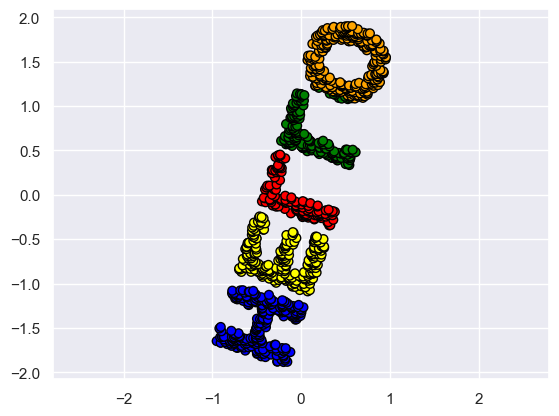

In [13]:
# Create an instance of the MDS model
model = MDS(n_components=2, random_state=1)

# Fit the MDS model to the 3D data and transform it to 2D
out3 = model.fit_transform(X3)

# Scatter plot the 2D transformed data
plt.scatter(
    out3[:, 0], 
    out3[:, 1], 
    c=X[:, 0],          
    s=40,                  
    cmap=custom_cmap,     
    edgecolor='black')

# Ensure the axes have equal scaling
plt.axis('equal');

This is essentially the goal of a manifold learning estimator: given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data.
In the case of MDS, the quantity preserved is the distance between every pair of points.

## Nonlinear Embeddings: Where MDS Fails

Our discussion thus far has considered *linear* embeddings, which essentially consist of rotations, translations, and scalings of data into higher-dimensional spaces.
Where MDS breaks down is when the embedding is nonlinear—that is, when it goes beyond this simple set of operations.
Consider the following embedding, which takes the input and contorts it into an "S" shape in three dimensions:

In [14]:
def make_hello_s_curve(X):
    
    # Compute a parameter t based on the first column of X
    t = (X[:, 0] - 2) * 0.75 * np.pi

    # Generate the x-coordinates for the s-curve using the sine function
    x = np.sin(t)

    # Keep the y-coordinates unchanged
    y = X[:, 1]

    # Compute the z-coordinates for the s-curve
    z = np.sign(t) * (np.cos(t) - 1)  # Using the cosine function and a sign adjustment to shape the curve

    # Stack x, y, z into a single 2D array and return it
    return np.vstack((x, y, z)).T

# Apply the s-curve transformation to the data X
XS = make_hello_s_curve(X)

This is again three-dimensional data, but we can see that the embedding is much more complicated:

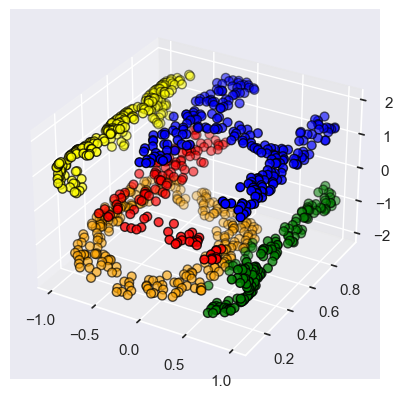

In [15]:
from mpl_toolkits import mplot3d

# Create a 3D axis for plotting
ax = plt.axes(projection='3d')

# Create a 3D scatter plot
ax.scatter3D(
    XS[:, 0],                # x-coordinates of the points
    XS[:, 1],                # y-coordinates of the points
    XS[:, 2],                # z-coordinates of the points
    c=X[:, 0],               # Color the points based on the x-coordinate of original data X
    s=40,                    # Size of the points in the scatter plot
    cmap=custom_cmap,        # Colormap for coloring the points
    edgecolor='black'        # Edge color of the points
);

The fundamental relationships between the data points are still there, but this time the data has been transformed in a nonlinear way: it has been wrapped-up into the shape of an "S."

If we try a simple MDS algorithm on this data, it is not able to "unwrap" this nonlinear embedding, and we lose track of the fundamental relationships in the embedded manifold:

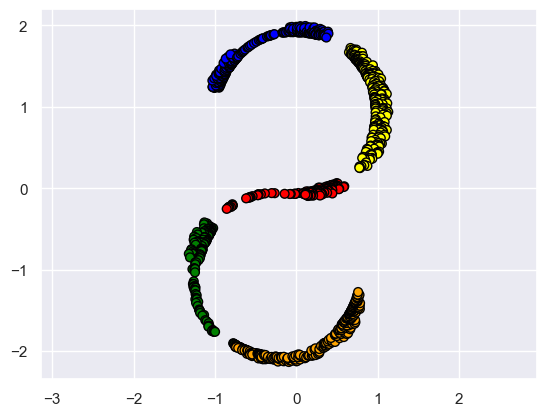

In [16]:
from sklearn.manifold import MDS

# Initialize MDS (Multidimensional Scaling) model
model = MDS(n_components=2, random_state=2)

# Fit the MDS model to the 3D data XS and transform it to 2D
outS = model.fit_transform(XS)

# Create a scatter plot of the 2D representation of the 3D data
plt.scatter(
    outS[:, 0], 
    outS[:, 1], 
    c=X[:, 0],          
    s=40,                  
    cmap=custom_cmap,     
    edgecolor='black')

# Ensure the aspect ratio of the plot is equal
plt.axis('equal');

The best two-dimensional *linear* embeding does not unwrap the S-curve, but instead throws out the original y-axis.

## Nonlinear Manifolds: Locally Linear Embedding

How can we move forward here? Stepping back, we can see that the source of the problem is that MDS tries to preserve distances between faraway points when constructing the embedding.
But what if we instead modified the algorithm such that it only preserves distances between nearby points?
The resulting embedding would be closer to what we want.

Visually, we can think of it as illustrated in this figure:

<left>
    <img src="images/05.10-LLE-vs-MDS.png" width="900" />
</left>

Here each faint line represents a distance that should be preserved in the embedding.
On the left is a representation of the model used by MDS: it tries to preserve the distances between each pair of points in the dataset.
On the right is a representation of the model used by a manifold learning algorithm called locally linear embedding (LLE): rather than preserving *all* distances, it instead tries to preserve only the distances between *neighboring points*: in this case, the nearest 100 neighbors of each point.

Thinking about the left panel, we can see why MDS fails: there is no way to flatten this data while adequately preserving the length of every line drawn between the two points.
For the right panel, on the other hand, things look a bit more optimistic. We could imagine unrolling the data in a way that keeps the lengths of the lines approximately the same.
This is precisely what LLE does, through a global optimization of a cost function reflecting this logic.

LLE comes in a number of flavors; here we will use the *modified LLE* algorithm to recover the embedded two-dimensional manifold.
In general, modified LLE does better than other flavors of the algorithm at recovering well-defined manifolds with very little distortion:

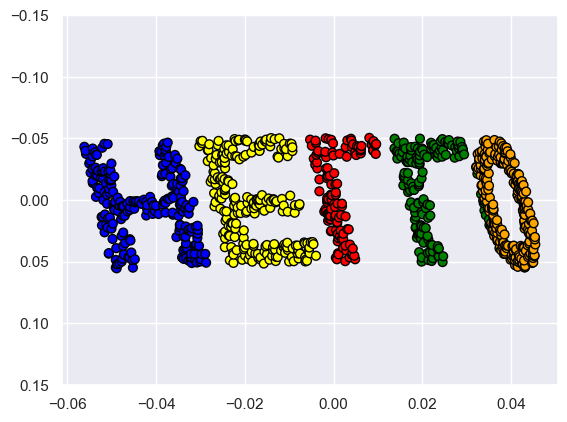

In [17]:
from sklearn.manifold import LocallyLinearEmbedding

# Initialize Locally Linear Embedding (LLE) model
model = LocallyLinearEmbedding(
    n_neighbors=100,         # Number of neighbors to use for local linearity
    n_components=2,          # Target number of dimensions for the reduced data
    method='modified',      # Use the modified LLE algorithm
    eigen_solver='dense'    # Solver to use for computing the eigenvalues
)

# Fit the LLE model to the 3D data XS and transform it to 2D
out4 = model.fit_transform(XS)

# Create a scatter plot for the 2D representation of the 3D data
fig, ax = plt.subplots()
ax.scatter(
    out4[:, 0], 
    out4[:, 1],
    c=X[:, 0],   
    s=40,                    
    cmap=custom_cmap,        
    edgecolor='black'        
)

# Set y-axis limits to ensure proper visualization
ax.set_ylim(0.15, -0.15);

The result remains somewhat distorted compared to our original manifold, but captures the essential relationships in the data!

#### Some Thoughts on Manifold Methods
Though this story and motivation is compelling, in practice manifold learning techniques tend to be finicky enough that they are rarely used for anything more than simple qualitative visualization of high-dimensional data.

The following are some of the particular challenges of manifold learning, which all contrast poorly with PCA:

* In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for missing data in PCA.
* In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components.
* The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.
* In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets you find the output dimension based on the explained variance.
* In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.
* In manifold learning the computational expense of manifold methods scales as O[N^2] or O[N^3]. For PCA, there exist randomized approaches that are generally much faster (though see the megaman package for some more scalable implementations of manifold learning).
With all that on the table, the only clear advantage of manifold learning methods over PCA is their ability to preserve nonlinear relationships in the data; for that reason I tend to explore data with manifold methods only after first exploring them with PCA.

Scikit-Learn implements several common variants of manifold learning beyond Isomap and LLE: the Scikit-Learn documentation has a nice discussion and comparison of them. Based on my own experience, I would give the following recommendations:

* For toy problems such as the S-curve we saw before, locally linear embedding (LLE) and its variants (especially modified LLE), perform very well. This is implemented in `sklearn.manifold.LocallyLinearEmbedding`.
* For high-dimensional data from real-world sources, LLE often produces poor results, and isometric mapping (IsoMap) seems to generally lead to more meaningful embeddings. This is implemented in `sklearn.manifold.Isomap`.
* For data that is highly clustered, t-distributed stochastic neighbor embedding (t-SNE) seems to work very well, though can be very slow compared to other methods. This is implemented in `sklearn.manifold.TSNE`.

If you're interested in getting a feel for how these work, I'd suggest running each of the methods on the data in this section.

# Isomap on Faces

One place manifold learning is often used is in understanding the relationship between high-dimensional data points.
A common case of high-dimensional data is images: for example, a set of images with 1,000 pixels each can be thought of as a collection of points in 1,000 dimensions – the brightness of each pixel in each image defines the coordinate in that dimension.

Here let's apply Isomap on some faces data.
We will use the Labeled Faces in the Wild dataset, which we previously saw in [In-Depth: Support Vector Machines](05.07-Support-Vector-Machines.ipynb) and [In Depth: Principal Component Analysis](05.09-Principal-Component-Analysis.ipynb).
Running this command will download the data and cache it in your home directory for later use:

In [18]:
from sklearn.datasets import fetch_lfw_people

# Fetch the Labeled Faces in the Wild (LFW) dataset
faces = fetch_lfw_people(min_faces_per_person=30)

# Print the shape of the data array
faces.data.shape

(2370, 2914)

We have 2,370 images, each with 2,914 pixels. In other words, the images can be thought of as data points in a 2,914-dimensional space!

Let's quickly visualize several of these images to see what we're working with:

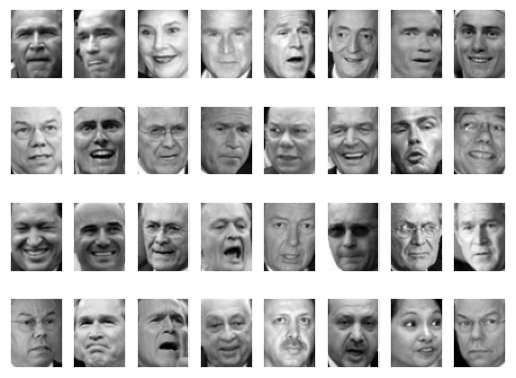

In [19]:
fig, ax = plt.subplots(4, 8,                                     # 4x8 grid
                       subplot_kw=dict(xticks=[], yticks=[]))    # Removes the x and y ticks from all subplots

for i, axi in enumerate(ax.flat): # Plot the first 32 images in a 4x8 grid
    
    axi.imshow(faces.images[i],   # Display the i-th image from the 'faces' dataset in the current subplot
               cmap='gray')       # Use grayscale colormap ('gray') to render the images

We would like to plot a low-dimensional embedding of the 2,914-dimensional data to learn the fundamental relationships between the images. One useful way to start is to compute a PCA, and examine the explained variance ratio, which will give us an idea of how many linear features are required to describe the data:

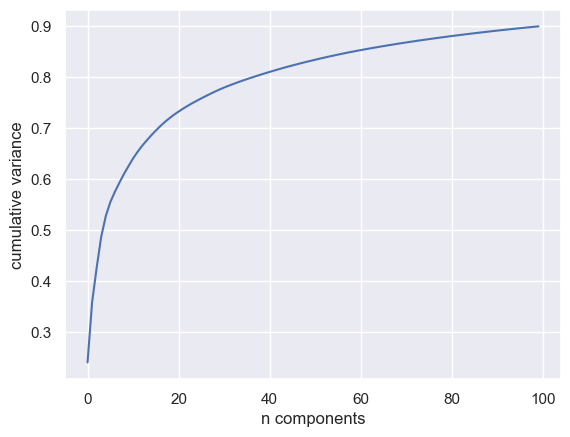

In [20]:
from sklearn.decomposition import PCA

# Initialize PCA with 100 components and randomized SVD solver
model = PCA(n_components=100, svd_solver='randomized').fit(faces.data)

# Plot the cumulative explained variance ratio
plt.plot(np.cumsum(model.explained_variance_ratio_)) # indicates how much of the total variance is explained by the first 'n' components
plt.xlabel('n components')                           # Label for the x-axis representing the number of principal components
plt.ylabel('cumulative variance');                   # Label for the y-axis showing the cumulative variance explained

We see that for this data, nearly 100 components are required to preserve 90% of the variance: this tells us that the data is intrinsically very high dimensional—it can't be described linearly with just a few components.

When this is the case, nonlinear manifold embeddings like LLE and Isomap can be helpful. We can compute an Isomap embedding on these faces using the same pattern shown before:

In [21]:
from sklearn.manifold import Isomap

# Initialize Isomap with 2 components for dimensionality reduction
model = Isomap(n_components=2)

# Fit the Isomap model and transform the faces data into 2D space
proj = model.fit_transform(faces.data)

# Print the shape of the resulting 2D projection
print(proj.shape)  # Expected output: (n_samples, 2)

(2370, 2)


The output is a two-dimensional projection of all the input images. To get a better idea of what the projection tells us, let's define a function that will output image thumbnails at the locations of the projections:

In [22]:
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    """
    Plots the 2D projection of high-dimensional data using a given model and optionally overlays image thumbnails.

    Parameters:
    - data: The high-dimensional data to be projected.
    - model: A dimensionality reduction model (e.g., PCA, Isomap) with a `fit_transform` method.
    - images: (Optional) A list or array of image thumbnails corresponding to the data points.
    - ax: (Optional) A Matplotlib axis object to plot on. If None, the current axis is used.
    - thumb_frac: Fraction of the plot's width to determine the minimum distance between images.
    - cmap: Colormap for the image thumbnails.
    """
    # Use the current axis if no axis is provided
    ax = ax or plt.gca()
    
    # Apply the dimensionality reduction model to the data
    proj = model.fit_transform(data)
    
    # Plot the 2D projection as black dots
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    # If image thumbnails are provided
    if images is not None:
        # Calculate the minimum distance to avoid overlapping thumbnails
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        
        # Initialize the list of shown images with a point far from the data
        shown_images = np.array([2 * proj.max(0)])
        
        for i in range(data.shape[0]):
            # Compute the distance of the current point to the shown images
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            
            # Skip the point if it's too close to any shown image
            if np.min(dist) < min_dist_2:
                continue
            
            # Add the current point to the list of shown images
            shown_images = np.vstack([shown_images, proj[i]])
            
            # Create an offset box with the image thumbnail
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                proj[i]
            )
            # Add the image thumbnail to the plot
            ax.add_artist(imagebox)

Calling this function now, we see the result:

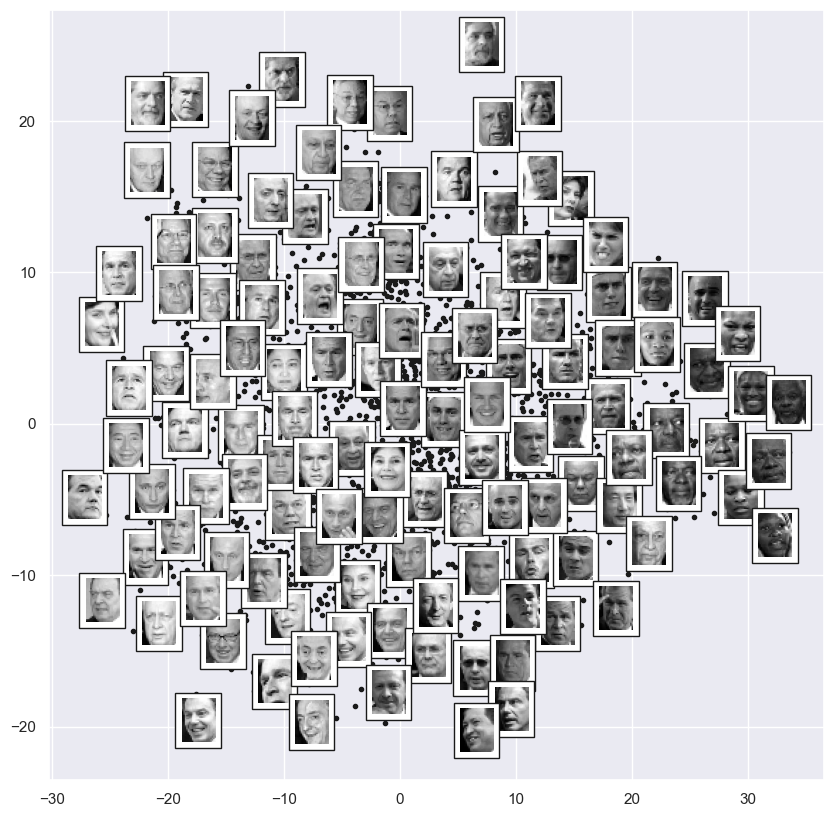

In [23]:
# Create a new figure with a size of 10x10 inches
fig, ax = plt.subplots(figsize=(10, 10))

# Call the plot_components function to visualize the faces data
# with dimensionality reduction performed by Isomap, and overlay image thumbnails
plot_components(
    faces.data,                       # High-dimensional face images data
    model=Isomap(n_components=2),     # Dimensionality reduction model (Isomap with 2 components)
    images=faces.images[:, ::2, ::2]  # Downsampled image thumbnails (using every 2nd pixel)
)

The result is interesting: the first two Isomap dimensions seem to describe global image features: the overall darkness or lightness of the image from left to right, and the general orientation of the face from bottom to top.
This gives us a nice visual indication of some of the fundamental features in our data.

We could then go on to classify this data (perhaps using manifold features as inputs to the classification algorithm) as we did in Support Vector Machines.

## Example: Visualizing Structure in Digits

As another example of using manifold learning for visualization, let's take a look at the MNIST handwritten digits set.
This data is similar to the digits we saw in [In-Depth: Decision Trees and Random Forests](05.08-Random-Forests.ipynb), but with many more pixels per image.
It can be downloaded from http://mldata.org/ with the Scikit-Learn utility:

In [24]:
from sklearn.datasets import fetch_openml

# Load the MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# Check the shape of the data
mnist.data.shape

(70000, 784)

This consists of 70,000 images, each with 784 pixels (i.e. the images are 28×28). As before, we can take a look at the first few images:

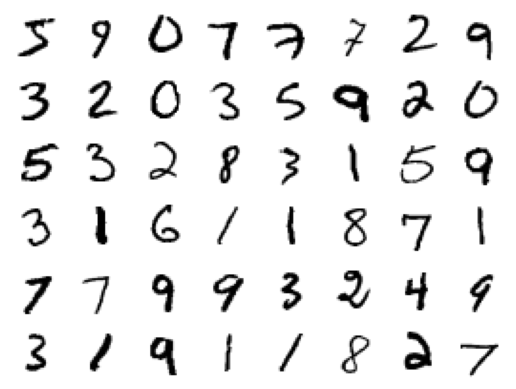

In [25]:
# Convert DataFrame to numpy array
mnist_data_array = mnist.data.values

# Create a figure and a 6x8 grid of subplots with no x and y ticks
fig, ax = plt.subplots(6, 8, subplot_kw=dict(xticks=[], yticks=[]))

# Iterate over each subplot and index in the flattened array of subplots
for i, axi in enumerate(ax.flat):
    
    # Display the MNIST image in the current subplot
    axi.imshow(mnist_data_array[1250 * i].reshape(28, 28), # Reshape the image data from a flattened vector into a 28x28 array
               cmap='gray_r')                              # Use 'gray_r' colormap to show the image in grayscale with reversed color mapping

This gives us an idea of the variety of handwriting styles in the dataset.

Let's compute a manifold learning projection across the data. For speed here, we'll only use 1/30 of the data, which is about ~2000 points (because of the relatively poor scaling of manifold learning, I find that a few thousand samples is a good number to start with for relatively quick exploration before moving to a full calculation):

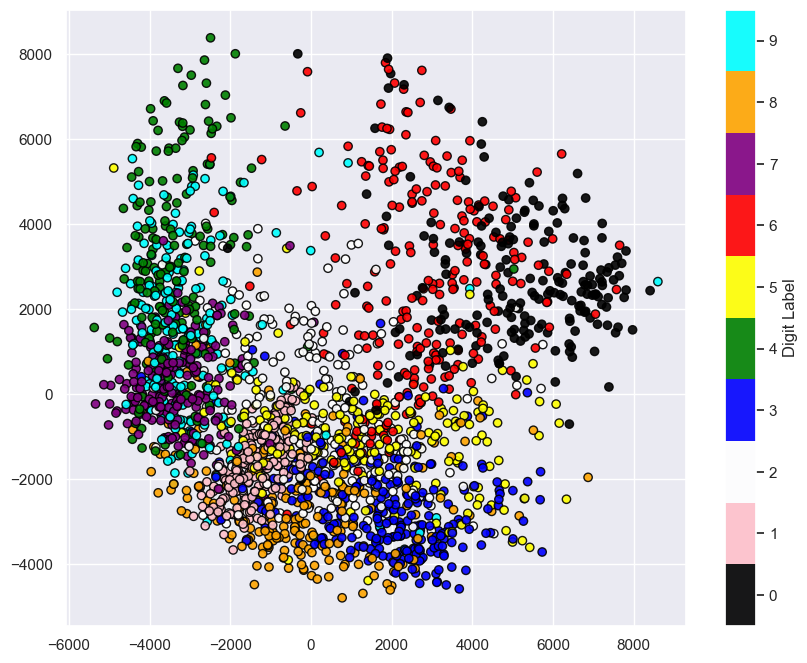

In [26]:
import matplotlib.colors as mcolors
from sklearn.manifold import Isomap
import matplotlib.pyplot as plt

# Use only 1/30 of the data
data = mnist.data[::30]
target = mnist.target[::30]

# Ensure the target is numeric
target_numeric = target.astype(int)

# Initialize the Isomap model with 2 components
model = Isomap(n_components=2)  # Isomap is a dimensionality reduction technique that preserves the geodesic distances between data points

# Fit the Isomap model to the data and transform it into a 2-dimensional space
proj = model.fit_transform(data)

# Define a custom colormap with a list of colors
colors = ['black', 'pink', 'white', 'blue', 'green', 'yellow', 'red', 'purple', 'orange', 'cyan']

cmap_name = 'custom_black_white_vivid'        # Name for the custom colormap
custom_cmap = mcolors.ListedColormap(colors)  # Create the custom colormap

# Plot the Isomap results
plt.figure(figsize=(10, 8))                      # Set the figure size
scatter = plt.scatter(proj[:, 0], proj[:, 1],    # Plot the 2D PCA projection
                      c=target_numeric,          # Color by digit label
                      edgecolor='black',          # No edge color for points
                      alpha=0.9,                 # Set transparency of points
                      cmap=custom_cmap)          # Use the custom colormap

plt.colorbar(scatter,                   # Associate the colorbar with the scatter plot
             label='Digit Label',       # Label for the colorbar
             ticks=range(10))           # Set colorbar ticks to match digit labels

plt.clim(-0.5, 9.5)                     # Adjust colorbar limits to match digit labels
plt.show();

The resulting scatter plot shows some of the relationships between the data points, but is a bit crowded. We can gain more insight by looking at just a single number at a time:

<class 'numpy.ndarray'>
(1970, 28, 28)


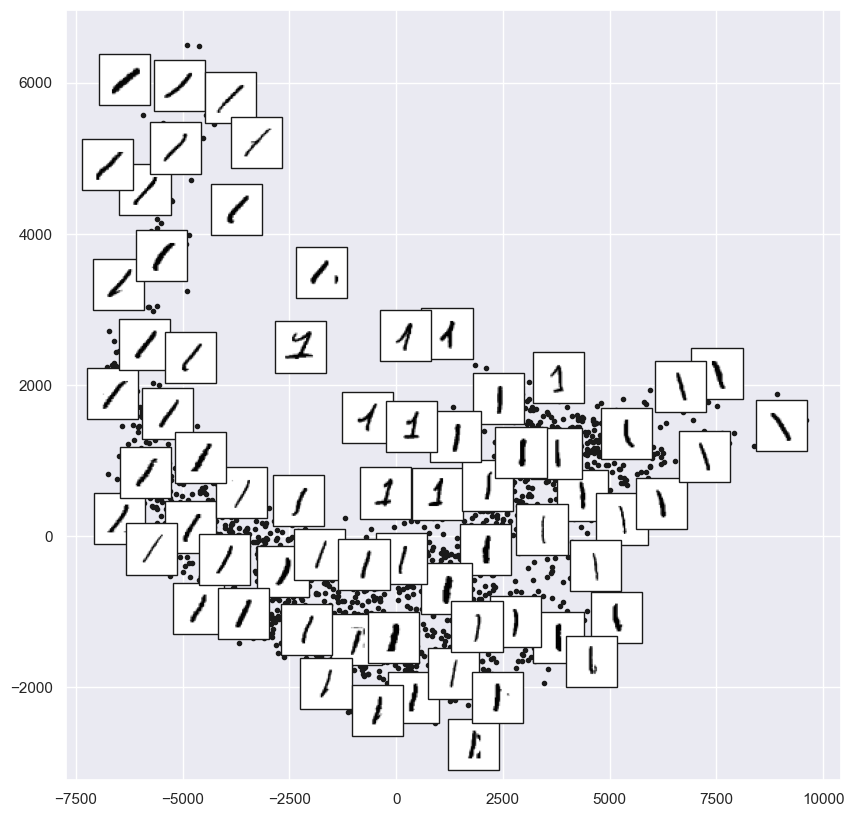

In [27]:
# Convert target values to integers
mnist.target = mnist.target.astype(int)

# Choose 1/4 of the "1" digits to project
data = mnist.data[mnist.target == 1][::4]

# Convert DataFrame to NumPy array and reshape it to 28x28 images
data_array = data.to_numpy().reshape(-1, 28, 28)
print(type(data_array))
print(data_array.shape)

# Define the Isomap model and plot
model = Isomap(n_neighbors=5, n_components=2, eigen_solver='dense')

fig, ax = plt.subplots(figsize=(10, 10))
plot_components(data.to_numpy(), model, images=data_array, ax=ax, thumb_frac=0.05, cmap='gray_r')

The result gives you an idea of the variety of forms that the number "1" can take within the dataset. The data lies along a broad curve in the projected space, which appears to trace the orientation of the digit. As you move up the plot, you find ones that have hats and/or bases, though these are very sparse within the dataset. The projection lets us identify outliers that have data issues: for example, pieces of the neighboring digits that snuck into the extracted images.

Now, this in itself may not be useful for the task of classifying digits, but it does help us get an understanding of the data, and may give us ideas about how to move forward, such as how we might want to preprocess the data before building a classification pipeline.